In [1]:
import os
import h5py #storing weights
import warnings
import itertools
warnings.filterwarnings('ignore')
import cv2 as cv #resize or reshape
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras import models
from keras.utils import to_categorical #Converts a class vector (integers) to binary class matrix.
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten #cnn layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses 
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
input_dir = 'dataset'
model_dir = 'model'

In [3]:
data = np.load('dataset/data.npz')

In [4]:
X = data['x'] / 255 #data #normalisation
Y = data['y'] #lables

In [5]:
print(X.shape, Y.shape)

(2041, 128, 128, 3) (2041, 2)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state=42)

In [7]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1836, 128, 128, 3) (1836, 2) (205, 128, 128, 3) (205, 2)


In [8]:
class_labels = ['Fake', 'Real']
no_classes = len(class_labels)
print(no_classes)

2


In [9]:
def display_image_samples(start, end, images):
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end+1):
        img = images[i:(i+1)]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(img[0,:,:,0], cmap='gray')
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

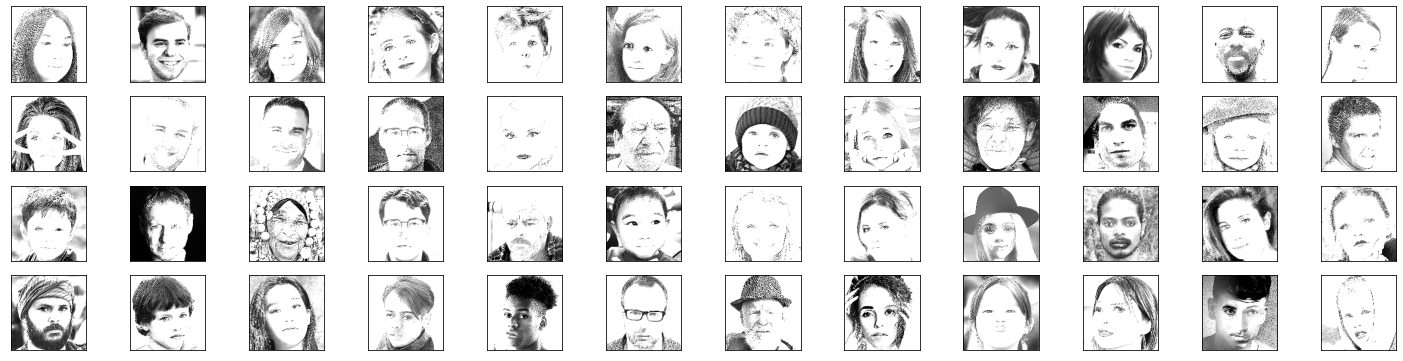

In [10]:
display_image_samples(0,47, X)

In [11]:
model = Sequential()

In [12]:
model.add(Conv2D(64, (5,5), activation='relu', padding='same', input_shape=(128, 128, 3))) #extract features
model.add(MaxPooling2D(pool_size=(2, 2))) #reduce the number of parameters when the images are too large
model.add(Conv2D(32, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5,5), activation='relu'))
model.add(Dropout(0.25)) #prevents overfitting
model.add(Flatten())#matrix is converted into one dimension
model.add(Dense(1024, activation="relu")) 
model.add(Dropout(0.25))
model.add(Dense(no_classes, activation="softmax"))

In [13]:
adam = Adam(lr=0.0001, decay=1e-06) #reduces step size
model.compile(
    loss='categorical_crossentropy', #loss function used for single label categorization.only one category is applicable for all data point
    optimizer=adam,
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        12816     
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [15]:
hist = model.fit(
    x= X,
    y= Y,
    batch_size= 16,
    epochs= 16,
    validation_data= (x_test, y_test),
    shuffle=True
)

Epoch 1/16
128/128 [==============================] - 118s 922ms/step - loss: 0.6909 - accuracy: 0.5385 - val_loss: 0.6675 - val_accuracy: 0.6000
Epoch 2/16
128/128 [==============================] - 133s 1s/step - loss: 0.6703 - accuracy: 0.5977 - val_loss: 0.6442 - val_accuracy: 0.6488
Epoch 3/16
128/128 [==============================] - 138s 1s/step - loss: 0.6401 - accuracy: 0.6423 - val_loss: 0.6175 - val_accuracy: 0.7122
Epoch 4/16
128/128 [==============================] - 136s 1s/step - loss: 0.6140 - accuracy: 0.6614 - val_loss: 0.5371 - val_accuracy: 0.7512
Epoch 5/16
128/128 [==============================] - 137s 1s/step - loss: 0.5816 - accuracy: 0.6918 - val_loss: 0.4993 - val_accuracy: 0.7366
Epoch 6/16
128/128 [==============================] - 137s 1s/step - loss: 0.5254 - accuracy: 0.7281 - val_loss: 0.4511 - val_accuracy: 0.8244
Epoch 7/16
128/128 [==============================] - 136s 1s/step - loss: 0.4750 - accuracy: 0.7658 - val_loss: 0.3847 - val_accuracy: 0.8

In [16]:
hist.params

{'verbose': 1, 'epochs': 16, 'steps': 128}

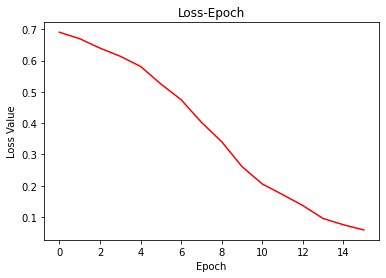

In [17]:
plt.plot(hist.history['loss'], color = 'red')
plt.title('Loss-Epoch')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.show()

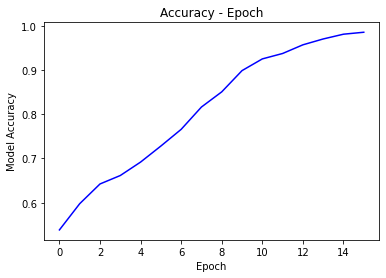

In [18]:
plt.plot(hist.history['accuracy'], color = 'blue')
plt.title('Accuracy - Epoch')
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.show()

In [19]:
y_pred = model.predict(x_test, batch_size=16)

In [20]:
#print(y_pred)

In [21]:
y_predict = []
for i in range(0, len(y_pred)):
    y_predict.append(int(np.argmax(y_pred[i])))
len(y_predict)

205

In [22]:
y_true = []
for i in range(0, len(y_test)):
    y_true.append(int(np.argmax(y_test[i])))
len(y_true)

205

In [23]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 30)
    plt.yticks(tick_marks, classes, rotation= 30)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

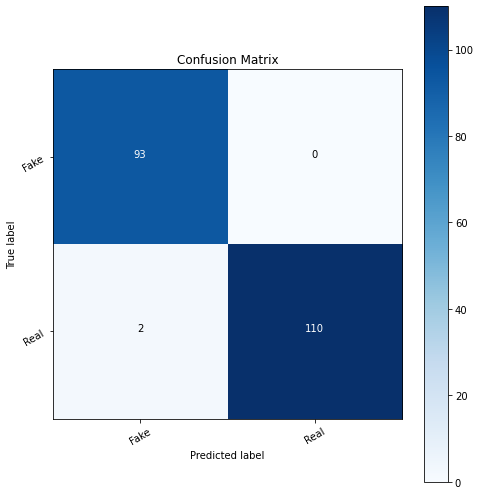

In [24]:
cm = confusion_matrix(y_true=y_true, y_pred=y_predict)
plot_confusion_matrix(cm, class_labels, title='Confusion Matrix')

In [25]:
print(classification_report(y_true=y_true,y_pred=y_predict))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        93
           1       1.00      0.98      0.99       112

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



In [26]:
model_structure = model.to_json()
f = Path("model/gab_model_structure.json")
f.write_text(model_structure)

3524

In [27]:
model.save_weights("model/gab_model_weights.h5")

In [32]:
import pickle

In [33]:
type(model)

tensorflow.python.keras.engine.sequential.Sequential

In [34]:
pickle.dump(model, open('Fake_Real_saved_modelV1.pkl', 'wb'))

TypeError: cannot pickle '_thread.RLock' object

In [ ]:
#!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(model, 'Animal_Gabor_saved_model.pkl') 

In [ ]:
class_dict = {}
count = 0
for cname in class_labels:
    class_dict[cname] = count
    count = count + 1
class_dict

In [ ]:
import json
with open("animal_class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

# Done